In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import nltk
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

In [90]:
df = pd.read_pickle('../saved_files/cleaned_df.pkl')

In [91]:
df.head()

,author,link,published,text,title,label,clean_title,clean_text
0,"[David Streitfeld, Natasha Singer, Steven Erla...",https://www.nytimes.com/2018/03/24/technology/...,2018-03-24T20:43:21,"There are other avenues still, said Jascha Kay...",How Calls for Privacy May Upend Business for F...,0,calls privacy may upend business facebook google,avenues still said jascha kaykas wolff chief m...
1,[Emily Flitter],https://www.nytimes.com/2018/03/24/business/we...,2018-03-24T17:16:53,"And so Mr. Tran, who is in his mid-50s and spe...",The Former Khmer Rouge Slave Who Blew the Whis...,0,former khmer rouge slave blew whistle wells fargo,mr tran mid 50s speaks english heavy vietnames...
2,[Keith Bradsher],https://www.nytimes.com/2018/03/25/business/ch...,2018-03-25T15:21:56,"In that analogy, Mr. Guo will essentially beco...","China Splits Top Jobs at Central Bank, Adding ...",0,china splits top jobs central bank adding anot...,analogy mr guo essentially become chairman chi...
3,[Ben Casselman],https://www.nytimes.com/2018/03/24/business/jo...,2018-03-25T03:00:18,News of Mr. Williams’s likely selection was fi...,A Top Candidate for New York Fed’s Leader: San...,0,top candidate new york feds leader san franciscos,news mr williamss likely selection first repor...
4,[Jim Tankersley],https://www.nytimes.com/2018/03/24/business/tr...,2018-03-24T14:34:10,What is increasingly clear to many on Capitol ...,"Trump’s Tariffs Keep Allies, Markets and Indus...",0,trumps tariffs keep allies markets industry gu...,increasingly clear many capitol hill business ...


In [92]:
# Preparing the target and predictors for modeling
# Keep the title and body text separated for different models

X_body_text = df['clean_text'].values
X_title_text = df['clean_title'].values
y = df['label'].values

Convert the text into a TF-IDF. 

TF-IDF counts the number of occurrences of each word in a document and divides the number of occurrences of each word in a document by the total number of words in the document: these new features are called TF for Term Frequencies.

Another refinement on top of TF is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.

This downscaling is called TF-IDF for “Term Frequency times Inverse Document Frequency”.

In [93]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_df= 0.85, min_df= 0.01)

In [94]:
X_body_tfidf = tfidf.fit_transform(X_body_text)
X_title_tfidf = tfidf.fit_transform (X_title_text)

In [95]:
indices = df.index.values

80% of articles for training, 20% for testing

In [96]:
X_body_tfidf_train, X_body_tfidf_test, \
y_body_train, y_body_test, \
indices_body_train, indices_body_test = train_test_split(X_body_tfidf, y, indices, test_size = 0.2, random_state=42)

In [97]:
df.loc[indices_body_train].groupby('label').agg('count')

,author,link,published,text,title,clean_title,clean_text
label,,,,,,,
0,363,363,363,363,363,363,363
1,141,141,141,141,141,141,141


In [98]:
df.loc[indices_body_test].groupby('label').agg('count')

,author,link,published,text,title,clean_title,clean_text
label,,,,,,,
0,100,100,100,100,100,100,100
1,27,27,27,27,27,27,27


In [99]:
from sklearn.naive_bayes import MultinomialNB

In [100]:
nb_body = MultinomialNB()

In [101]:
nb_body.fit(X_body_tfidf_train, y_body_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In sample predictions and metrics

In [102]:
y_body_train_pred = nb_body.predict(X_body_tfidf_train)

In [103]:
print('Naive Bayes In Sample F1 and Accuracy Scores:')
print('F1 score {:.4}%'.format(f1_score(y_body_train, y_body_train_pred, average='macro')*100 ))
print ('Accuracy score {:.4}%'.format(accuracy_score(y_body_train, y_body_train_pred)*100))

Naive Bayes In Sample F1 and Accuracy Scores:
F1 score 99.51%
Accuracy score 99.6%


In [104]:
np.where(y_body_train != y_body_train_pred)

(array([ 52, 449]),)

These are the two misclassified articles in the In-Sample group. They were **Ham** misclassified as **Spam**.

In [105]:
df.loc[[52, 449]]

,author,link,published,text,title,label,clean_title,clean_text
52,"[Carl Zimmer, Profiles In Science]",https://www.nytimes.com/2018/03/20/science/dav...,2018-03-20T19:41:01,These people almost entirely replaced the earl...,David Reich Unearths Human History Etched in Bone,0,david reich unearths human history etched bone,people almost entirely replaced earlier farmer...
449,[Oliver Roeder],https://fivethirtyeight.com/features/blockchai...,2018-03-07T18:13:42,The Blockchain Is Just Another Way To Make Art...,The Blockchain Is Just Another Way To Make Art...,0,blockchain another way make art money,blockchain another way make art money commerci...


In [106]:
for article in dirty_df.loc[[52, 449], 'text']:
    print(article)
    print('--------------\n\n\n\n')

These people almost entirely replaced the earlier farmers. Today, British people trace 90 percent of their ancestry to this immigrant wave.

Were it not for the genetic findings, “nobody would have believed the scale of the turnover,” said Ian Armit, an archaeologist at the University of Bradford who collaborated with Dr. Reich on the research.

Advertisement Continue reading the main story

“Archaeologists will need to get to grips with this 90 percent replacement, and what this might really mean in human terms,” he added.

A Dramatic Voyage

The Beaker people needed only to cross the English Channel to get to the British Isles. A far more spectacular voyage took place about 3,300 years ago, when humans first sailed to remote islands in the Pacific.

Dr. Reich and his colleagues have shed light on that migration by analyzing ancient DNA from the skeletons of early Pacific voyagers.

“It’s changed the game,” said Matthew Spriggs, an archaeologist at Australian National University, who 

Out of sample predictions and metrics

In [107]:
y_body_pred = nb_body.predict(X_body_tfidf_test)

In [108]:
# print metrics
print('Naive Bayes F1 and Accuracy Scores:')
print('F1 score {:.4}%'.format(f1_score(y_body_test, y_body_pred, average='macro')*100 ))
print ('Accuracy score {:.4}%'.format(accuracy_score(y_body_test, y_body_pred)*100))

Naive Bayes F1 and Accuracy Scores:
F1 score 98.81%
Accuracy score 99.21%


In [109]:
np.where(y_body_test != y_body_pred)

(array([0]),)

This is the misclassified article in the Out-of-sample group. It was **Ham** misclassified as **Spam**.

In [110]:
df.loc[0]

author         [David Streitfeld, Natasha Singer, Steven Erla...
link           https://www.nytimes.com/2018/03/24/technology/...
published                                    2018-03-24T20:43:21
text           There are other avenues still, said Jascha Kay...
title          How Calls for Privacy May Upend Business for F...
label                                                          0
clean_title     calls privacy may upend business facebook google
clean_text     avenues still said jascha kaykas wolff chief m...
Name: 0, dtype: object

In [111]:
print(dirty_df.loc[0, 'text'])

There are other avenues still, said Jascha Kaykas-Wolff, the chief marketing officer of Mozilla, the nonprofit organization behind the popular Firefox browser, including advertisers and large tech platforms collecting vastly less user data and still effectively customizing ads to consumers.

“They are just collecting all the data to try to find magic growth algorithms,” Mr. Kaykas-Wolff said of online marketers. This past week, Mozilla halted its ads on Facebook, saying the social network’s default privacy settings allowed access to too much data.

The greatest likelihood is that the internet companies, frightened by the tumult, will accept a few more rules and work a little harder for transparency. And there will be hearings on Capitol Hill.

The next chapter is also set to play out not in Washington but in Europe, where regulators have already cracked down on privacy violations and are examining the role of data in online advertising.

Photo

The Cambridge Analytica case, said Vera J

### Spam Word Counts and Wordcloud

In [112]:
spam = df[df['label']==1]

In [113]:
spam_words = nltk.word_tokenize(" ".join(spam['clean_text'].values.tolist()))

In [114]:
spam_counter = Counter(spam_words)
print(spam_counter.most_common(50))

[('market', 4724), ('report', 1684), ('global', 1110), ('industry', 826), ('analysis', 717), ('research', 707), ('2018', 658), ('sales', 656), ('key', 635), ('regions', 531), ('growth', 530), ('also', 498), ('share', 464), ('product', 454), ('revenue', 448), ('forecast', 369), ('chapter', 337), ('players', 325), ('production', 311), ('information', 303), ('type', 284), ('applications', 278), ('data', 275), ('application', 274), ('end', 250), ('major', 236), ('america', 236), ('company', 228), ('materials', 228), ('sandle', 218), ('manufacturers', 215), ('size', 213), ('development', 212), ('based', 210), ('study', 206), ('trends', 205), ('period', 204), ('basis', 204), ('demand', 203), ('chain', 203), ('chinese', 200), ('factors', 198), ('manufacturing', 195), ('includes', 193), ('region', 187), ('2023', 184), ('future', 181), ('top', 173), ('along', 167), ('overview', 163)]


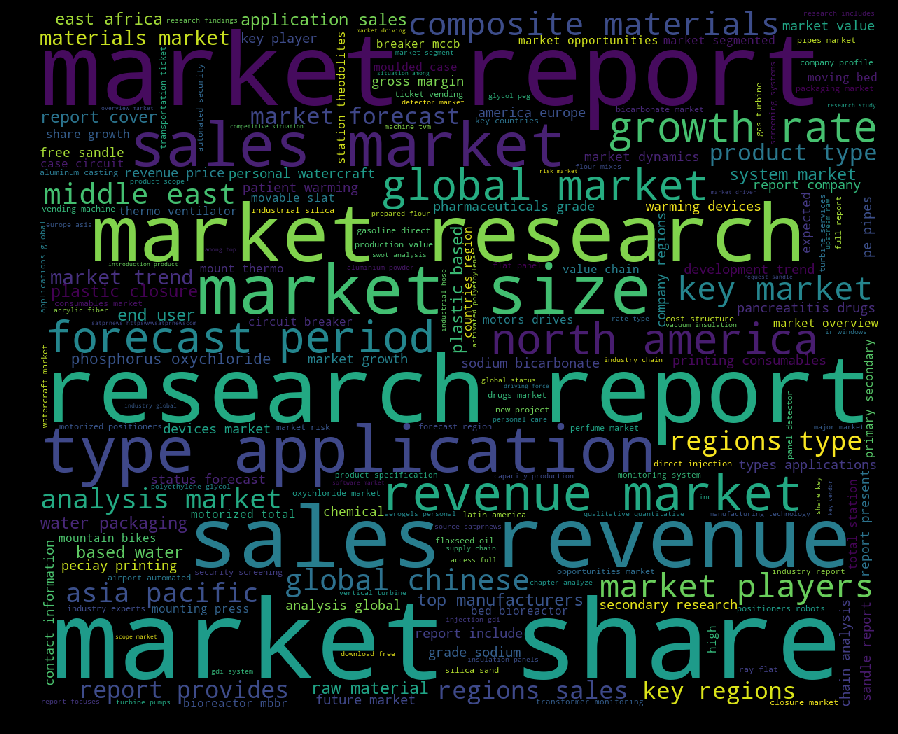

In [115]:
spam_wordcloud = WordCloud(width=1200, height=1000, random_state = 42).generate(" ".join(spam_words))
# wordcloud2 = WordCloud(width=1200, height=1000, collocations = False).generate(" ".join(spam_words)) # to turn off bigrams

fig = plt.figure(figsize=(20,10), facecolor = 'k')
plt.imshow(spam_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [116]:
spam_bigrams = nltk.bigrams(spam_words)

In [117]:
spam_counter = Counter(spam_bigrams)
print(spam_counter.most_common(10))

[(('market', 'share'), 350), (('research', 'report'), 300), (('market', 'report'), 275), (('sales', 'revenue'), 249), (('market', 'research'), 206), (('market', 'size'), 168), (('type', 'application'), 157), (('report', 'also'), 155), (('2018', '2023'), 151), (('revenue', 'market'), 142)]


### Ham Wordcounts and Wordcloud

In [118]:
ham = df[df['label']==0]

In [119]:
ham_words = nltk.word_tokenize(" ".join(ham['clean_text'].values.tolist()))

In [120]:
ham_counter = Counter(ham_words)
print(ham_counter.most_common(50))

[('``', 2129), ("''", 2111), ('said', 1502), ("'s", 785), ('people', 738), ('new', 733), ('would', 721), ('one', 710), ('mr', 629), ('like', 607), ('also', 573), ('?', 569), ('us', 522), ('could', 511), ('year', 508), ('data', 495), ('facebook', 494), ('time', 486), ('percent', 443), ('even', 432), ('its', 429), ('trump', 426), ('years', 421), ('it', 400), ('first', 385), ('company', 384), ('many', 381), ('two', 376), ('make', 374), ('the', 349), ('market', 341), ('companies', 337), ('last', 337), ('story', 321), ('%', 319), ('may', 317), ('get', 317), ('much', 310), ('continue', 304), ('work', 301), ('business', 299), ('way', 299), ('main', 298), ('times', 289), ('think', 285), ('still', 282), ('world', 281), ('well', 276), ('i', 275), ('research', 269)]


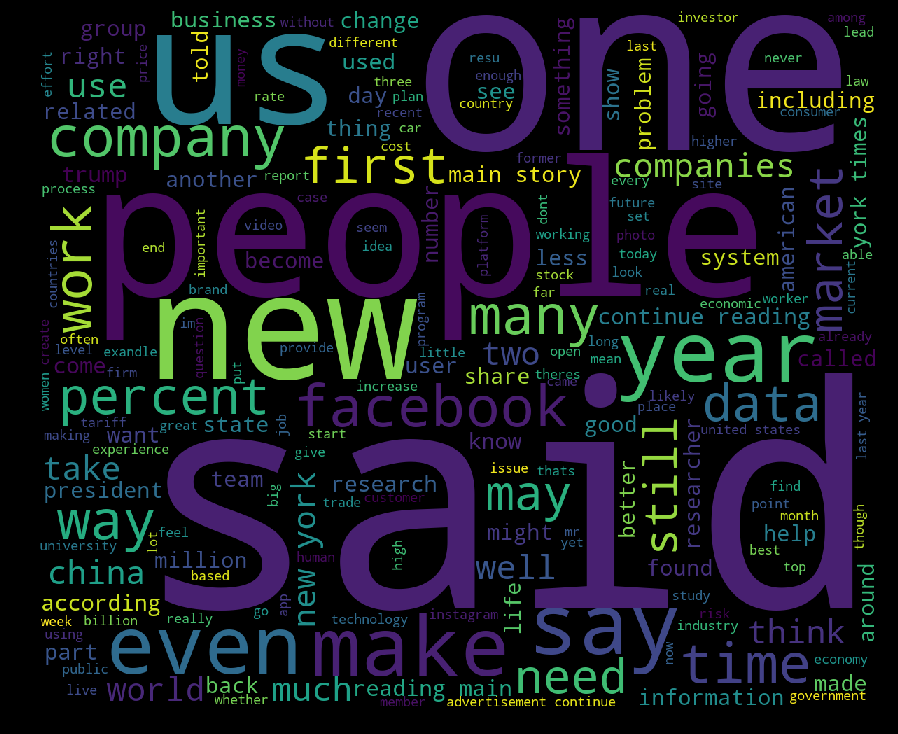

In [121]:
ham_wordcloud = WordCloud(width=1200, height=1000, random_state = 42).generate(" ".join(ham_words))

fig = plt.figure(figsize=(20,10), facecolor = 'k' )
plt.imshow(ham_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [122]:
ham_bigrams = nltk.bigrams(ham_words)

In [123]:
ham_counter = Counter(ham_bigrams)
print(ham_counter.most_common(10))

[(("''", 'said'), 330), (('new', 'york'), 253), (('continue', 'reading'), 238), (('reading', 'main'), 238), (('main', 'story'), 236), (('said', '``'), 201), (('york', 'times'), 181), (('``', 'i'), 170), (('advertisement', 'continue'), 160), (('``', 'the'), 143)]
